In [89]:
import tweepy
import json
import pandas as pd
import re
import nltk
from textblob import TextBlob


api_key = "aJTgi4d1H1zmQNkQuHeualNhP"
api_secrets = "yPFdp2Bbib25r1iPQCqBuPq8B9UzoJbIdpv1jgzEZFEg1eJl6X"
access_token = "1409382627124019204-oPpzVGuCwyFfQTfoocFhgHi68whhog"
access_secret = "esgwpH5gnRfNB0SpiHkO52mZSI5VKKnn8SG2pafEnzj2b"
 
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secrets)
auth.set_access_token(access_token,access_secret)
 
api = tweepy.API(auth)

TWEET_OBJECT_PATH = 'tweet-objects/'

 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed Authentication')

Successful Authentication


In [41]:
def get_ids(filename):
    file = open(filename)
    threads = file.readlines()
    file.close()
    return [thread.replace('\n', '').split(',') for thread in threads]

def get_labels(filename):    
    file = open(filename)
    labels = file.readlines()
    file.close()
    return [label.replace('\n', '') for label in labels]

In [42]:
train_ids = get_ids('train.data.txt')
train_labels = get_labels('train.label.txt')

dev_ids = get_ids('dev.data.txt')
dev_labels = get_labels('dev.label.txt')

test_ids = get_ids('test.data.txt')

print(train_ids[0])
print()
print(train_labels[0])

['1250219300389974016', '1250219116993974272', '1250219437027766273', '1250219620939657216', '1250219777185873922', '1250219894429208577', '1250219998842216448', '1250220115762667520', '1250220272306638848', '1250220389323526146', '1250220527005753344', '1250220791544705025', '1250220987238383616', '1250221140603047937', '1250221275827470336', '1250221402822545410']

nonrumour


In [43]:
flat_train_ids = [id_ for id_list in train_ids for id_ in id_list]
flat_dev_ids = [id_ for id_list in dev_ids for id_ in id_list]
flat_test_ids = [id_ for id_list in test_ids for id_ in id_list]

unique_ids = list(set(flat_train_ids + flat_dev_ids))

In [44]:
# tweet id: full text of tweet if found by api, otherwise text from tweet-objects
tweets_dict = {}

def get_train_tweets_from_api(ids):
    for i in range(0, len(ids), 100):
        split = ids[i:i+100]
        for tweet in api.lookup_statuses(split, tweet_mode='extended'):
            tweets_dict[tweet.id_str] = tweet.full_text

def get_test_tweets(ids):
    for id_ in ids:
        file = open(f'tweet-objects/{id_}.json')
        tweet_object = json.load(file)
        file.close()
        tweets_dict[tweet_object['id_str']] = tweet_object['text']

In [45]:
get_train_tweets_from_api(unique_ids)
get_test_tweets(flat_test_ids)

print(tweets_dict[unique_ids[0]])
print(tweets_dict[unique_ids[-1]])
print(tweets_dict[flat_test_ids[0]])

Another Dark Day. @PwnParrot @Boogie2988
@TheValleyReport why are the hot ones so crazy? Cuz God says so. Mysterious ways whatever.
How Does COVID-19 Spread? https://t.co/TXHDeUpetg https://t.co/IyyirWcKSp


In [46]:
tweet_ids_df = pd.DataFrame({'id': tweets_dict.keys(), 'text': tweets_dict.values()}, index=tweets_dict.keys())
tweet_ids_df.head()

,id,text
552706985087361025,552706985087361025,This dog was abandoned at a Scottish railway s...
1250166679012872194,1250166679012872194,@TIME The problem \n\nis not corona!\n\nproble...
614613076432801792,614613076432801792,@petesouza @vj44 this president turns a once h...
519867203638657025,519867203638657025,“@ComplexMag: Someone spray painted a penis on...
674265577293156353,674265577293156353,@RollingStone there's some good news crime &am...


In [47]:
tweet_ids_df.to_csv('tweets_id_text.csv', header=True)

In [48]:
tweet_ids_df = pd.read_csv('tweets_id_text.csv', index_col=0) 
tweet_ids_df.head()

,id,text
552706985087361025,552706985087361025,This dog was abandoned at a Scottish railway s...
1250166679012872194,1250166679012872194,@TIME The problem \n\nis not corona!\n\nproble...
614613076432801792,614613076432801792,@petesouza @vj44 this president turns a once h...
519867203638657025,519867203638657025,“@ComplexMag: Someone spray painted a penis on...
674265577293156353,674265577293156353,@RollingStone there's some good news crime &am...


In [49]:
def encode_label(label):
    # rumour: 1, nonrumour: 0
    if label == 'rumour':
        return 1
    return 0


def concatenate_tweets(source, reply_ids):
    concat = source
    
    for id_ in reply_ids:
        try:
            tweet = tweet_ids_df.loc[int(id_), 'text'] # may throw key error
            concat += ' ' + tweet
        except:
            continue
    concat = concat.strip()
    
    return concat


def create_dataframe(ids, labs, include_labels=True):
    source_ids = []
    reply_ids_list = []
    concat_tweets = []
    labels = []
    
    for i in range(len(ids)):
        # add concatenation of source and reply tweets to concat_tweets
        try:
            source = tweet_ids_df.loc[int(ids[i][0]), 'text'] # may throw key error
            if len(ids[i]) > 1:
                concat = concatenate_tweets(source, ids[i][1:])
            concat_tweets.append(concat)
        except:
            if include_labels:
                continue # skip instance if source tweet is missing
            else:
                concat_tweets.append('')

        # add id of source tweet to source_ids
        source_ids.append(ids[i][0])

        # add list of ids of reply tweets to reply_ids_list if there are replies
        if len(ids[i]) > 1:
            reply_ids_list.append(ids[i][1:])
        else:
            reply_ids_list.append([])              

        if include_labels:
            # add encoded label to labels (1 for rumour, 0 for nonrumour)
            label = encode_label(labs[i])
            labels.append(label)

    df = pd.DataFrame({'source_id': source_ids, 
                   'reply_ids': reply_ids_list,
                   'concat_tweet': concat_tweets})
    
    if include_labels:
        df['label'] = labels
    
    return df

In [77]:
train_full_df = create_dataframe(train_ids, train_labels)
train_full_df.head()

,source_id,reply_ids,concat_tweet,label
0,1250219300389974016,"[1250219116993974272, 1250219437027766273, 125...",5. Can regularly rinsing your nose with saline...,0
1,554886875303780352,"[554894001946759168, 554959644125167617, 55492...",French police chief killed himself after #Char...,1
2,1237901309011021825,"[1237901311439450112, 1239862502516760577]",Coronavirus disease (COVID-19) advice for the ...,0
3,524958128392376320,"[524961934064754688, 524959028061798401, 52495...",Ottawa police confirm that there were multiple...,0
4,1239295488677085185,[1239562248990806016],if the primary focus of a government isn't to ...,0


In [78]:
dev_full_df = create_dataframe(dev_ids, dev_labels)
dev_full_df.head()

,source_id,reply_ids,concat_tweet,label
0,1249004694950817796,[1249011200068730880],COVID-19 Fact:\nAre hand dryers effective in k...,0
1,1267552274819227649,"[1270394169836568576, 1270502071175909376]",@atruchecks when can we expect the result of m...,0
2,1235238334722699265,"[1235234904281165825, 1235234927937048577, 123...",How does COVID-19 spread? \n\nPeople can catch...,0
3,1248746792914546688,[1248775858120097792],"every news outlet using headlines like,\n\n""ar...",0
4,523820806917603328,"[523943560589361152, 524027059346370560, 53048...",Researcher @naskrecki on his encounter with a ...,0


In [79]:
test_full_df = create_dataframe(test_ids, None, include_labels=False)
test_full_df.head()

,source_id,reply_ids,concat_tweet
0,1246482832316301319,[1247355493988909056],How Does COVID-19 Spread? https://t.co/TXHDeUp...
1,1252279738099433473,"[1251884146403815428, 1252033306100670464, 125...","@brain_warrior I hate to keep saying it, but C..."
2,1236050255394877440,"[1236050046950481922, 1236050331940855808]",Q. How are COVID-19 and influenza viruses diff...
3,1235582115900796928,"[1235584239497867275, 1235585067973578752, 123...",Una de les Q&amp;A on coronaviruses de la pàgi...
4,1258787515592572928,"[1258710626676899840, 1258711444075565058, 125...",@_truthpolitics We should absolutely blame the...


In [80]:
train_full_df.drop(['source_id','reply_ids'],axis=1,inplace=True)
dev_full_df.drop(['source_id','reply_ids'],axis=1,inplace=True)
test_full_df.drop(['source_id','reply_ids'],axis=1,inplace=True)
train_full_df.head()

,concat_tweet,label
0,5. Can regularly rinsing your nose with saline...,0
1,French police chief killed himself after #Char...,1
2,Coronavirus disease (COVID-19) advice for the ...,0
3,Ottawa police confirm that there were multiple...,0
4,if the primary focus of a government isn't to ...,0


In [82]:
def preprocess_df(df):
    preprocessed = df
    text = list(preprocessed['concat_tweet'])
    sentiment = []
    for i in range(len(text)):
        text[i] = " ".join(filter(lambda x:x[0]!='@', text[i].split()))
        text[i] = " ".join(filter(lambda x:x[0:4]!='http', text[i].split()))
        text[i] = " ".join(filter(lambda x:x[0:4]!='&amp', text[i].split()))
        text[i] = re.sub(r'[^a-zA-Z ]','',text[i])
        text[i] = " ".join(filter(lambda x:x[0:1]!='Q', text[i].split()))
        text[i] = " ".join(filter(lambda x:x[0:1]!='A', text[i].split()))
        sentiment.append(TextBlob(text[i]).sentiment.polarity)
    preprocessed['concat_tweet'] = text 
    preprocessed.insert(1, 'sentiment',sentiment)
    preprocessed.fillna('', inplace=True)
    #sources.text = sources.text + " " + sources.hashtag
    preprocessed.drop_duplicates(subset=['concat_tweet'][0:100],inplace=True)
    return preprocessed

In [83]:
train_full_df = preprocess_df(train_full_df)
dev_full_df = preprocess_df(dev_full_df)
test_full_df = preprocess_df(test_full_df)
train_full_df.head()

,concat_tweet,sentiment,label
0,Can regularly rinsing your nose with saline he...,0.173437,0
1,French police chief killed himself after Charl...,-0.278125,1
2,Coronavirus disease COVID advice for the publi...,0.133333,0
3,Ottawa police confirm that there were multiple...,0.133333,0
4,if the primary focus of a government isnt to a...,0.400000,0


In [100]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet

tt = TweetTokenizer()
stopwords = set(stopwords.words('english')) #note: stopwords are all in lowercase
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma


def tokenize_df(df):
    tokenized_df = df
    tokenized_sentence = []
    for _id, row in tokenized_df.iterrows():
        text = row['concat_tweet']
        # tokenize tweet
        tokens = tt.tokenize(text)
        # convert to lowercase
        tokens = [tok.lower() for tok in tokens]
        # remove stopwords
        tokens = [tok for tok in tokens if tok not in stopwords]
        # lemmatize
        tokens = [lemmatize(tok) for tok in tokens]
        tokenized_sentence.append(tokens)
    tokenized_df.insert(1, 'tokens', tokenized_sentence)
    tokenized_df.drop('concat_tweet',axis=1,inplace=True)
    return tokenized_df

In [103]:
train_full_df = tokenize_df(train_full_df)
train_full_df.head()

,tokens,sentiment,label
0,"[regularly, rinse, nose, saline, help, prevent...",0.173437,0
1,"[french, police, chief, kill, charliehebdo, at...",-0.278125,1
2,"[coronavirus, disease, covid, advice, public, ...",0.133333,0
3,"[ottawa, police, confirm, multiple, suspect, s...",0.133333,0
4,"[primary, focus, government, isnt, alleviate, ...",0.400000,0


In [104]:
dev_full_df = tokenize_df(dev_full_df)
dev_full_df.head()

,tokens,sentiment,label
0,"[covid, fact, hand, dryer, effective, kill, ne...",0.484091,0
1,"[expect, result, husband, pendingantibody, tes...",0.000000,0
2,"[covid, spread, people, catch, covid, others, ...",0.026257,0
3,"[every, news, outlet, use, headline, like, ant...",-0.056439,0
4,"[researcher, encounter, goliath, birdeater, wo...",0.168182,0


In [105]:
test_full_df = tokenize_df(test_full_df)
test_full_df.head()

,tokens,sentiment
0,"[covid, spread, thank, wcco, station, trust, m...",0.183333
1,"[hate, keep, say, capitalism, implode, without...",-0.160000
2,"[covid, influenza, virus, different, covid, co...",0.100000
3,"[una, de, le, coronaviruses, de, la, pgina, we...",0.068466
4,"[absolutely, blame, politician, whoever, else,...",0.333333


In [109]:
def count_tokens(df):
    token_counts = {}
    for token_list in list(df['tokens']):
        for token in token_list:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1
    return {k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1],reverse=True)}
            
unigram_counts = count_tokens(train_full_df)
unigram_counts

{'covid': 2252,
 'coronavirus': 1901,
 'people': 1641,
 'new': 1557,
 'virus': 1072,
 'get': 870,
 'like': 786,
 'say': 785,
 'dont': 646,
 'prevent': 607,
 'make': 590,
 'know': 581,
 'go': 580,
 'kill': 579,
 'spread': 550,
 'one': 536,
 'take': 534,
 'think': 529,
 'need': 520,
 'see': 508,
 'u': 495,
 'disease': 481,
 'would': 476,
 'hand': 474,
 'rt': 448,
 'good': 445,
 'test': 443,
 'person': 430,
 'symptom': 419,
 'protect': 411,
 'time': 410,
 'infect': 398,
 'use': 398,
 'infection': 388,
 'im': 378,
 'help': 374,
 'may': 371,
 'thats': 363,
 'day': 360,
 'spider': 360,
 'die': 351,
 'effective': 349,
 'work': 347,
 'case': 337,
 'cough': 336,
 'give': 336,
 'cause': 327,
 'death': 317,
 'want': 315,
 'someone': 314,
 'treat': 311,
 'report': 309,
 'mask': 306,
 'look': 303,
 'wear': 302,
 'come': 302,
 'shoot': 300,
 'catch': 298,
 'transmit': 295,
 'also': 294,
 'still': 283,
 'way': 278,
 'even': 277,
 'nose': 276,
 'thank': 275,
 'vaccine': 268,
 'find': 268,
 'right': 26

In [158]:
def top_n(df, n):
    return list(df.columns)+list(unigram_counts.keys())[0:n]

def df_top_tokens(df, cols):
    df_new = df
    df_new = df_new.reindex(columns=cols, fill_value=0)
    for i, row in df_new.iterrows():
        for token in row['tokens']:
            if token in list(df_new.columns):
                df_new.at[i, token] = 1
    df_new.drop(['tokens'],axis=1,inplace=True)
    return df_new


cols_500 = top_n(train_full_df, 500)
cols_1000 = top_n(train_full_df, 1000)

y_train = train_full_df['label']
y_dev = dev_full_df['label']

train_full_df.drop('label',axis=1,inplace=True)
dev_full_df.drop('label',axis=1,inplace=True)

train_df_500 = df_top_tokens(train_full_df, cols_500)
dev_df_500 = df_top_tokens(dev_full_df, cols_500)
test_df_500 = df_top_tokens(test_full_df, cols_500)

train_df_1000 = df_top_tokens(train_full_df, cols_1000)
dev_df_1000 = df_top_tokens(dev_full_df, cols_1000)
test_df_1000 = df_top_tokens(test_full_df, cols_1000)

In [159]:
train_df_500

,sentiment,label,covid,coronavirus,people,new,virus,get,like,say,...,employee,continue,reality,lord,attack,law,x,order,post,id
0,0.173437,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.278125,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.133333,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.133333,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.040770,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1563,-0.191270,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1564,0.011903,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1565,-0.057692,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
from sklearn.preprocessing import MinMaxScaler

scaler_500 = MinMaxScaler().fit(train_df_500['sentiment'].values.reshape(-1,1))
scaler_1000 = MinMaxScaler().fit(train_df_1000['sentiment'].values.reshape(-1,1))

train_df_500['sentiment'] = scaler_500.transform(train_df_500['sentiment'].values.reshape(-1,1))
dev_df_500['sentiment'] = scaler_500.transform(dev_df_500['sentiment'].values.reshape(-1,1))
test_df_500['sentiment'] = scaler_500.transform(test_df_500['sentiment'].values.reshape(-1,1))

train_df_1000['sentiment'] = scaler_1000.transform(train_df_1000['sentiment'].values.reshape(-1,1))
dev_df_1000['sentiment'] = scaler_1000.transform(dev_df_1000['sentiment'].values.reshape(-1,1))
test_df_1000['sentiment'] = scaler_1000.transform(test_df_1000['sentiment'].values.reshape(-1,1))

train_df_500

,sentiment,label,covid,coronavirus,people,new,virus,get,like,say,...,employee,continue,reality,lord,attack,law,x,order,post,id
0,0.586719,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.360938,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.566667,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.566667,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.700000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.520385,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1563,0.404365,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1564,0.505952,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1565,0.471154,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train on 1555 samples, validate on 531 samples
Epoch 1/4000
1555/1555 [==============================] - 1s 551us/step - loss: 0.4218 - accuracy: 0.8051 - val_loss: 0.3696 - val_accuracy: 0.8136
Epoch 2/4000
1555/1555 [==============================] - 0s 295us/step - loss: 0.2362 - accuracy: 0.8952 - val_loss: 0.2870 - val_accuracy: 0.8682
Epoch 3/4000
1555/1555 [==============================] - 0s 267us/step - loss: 0.1258 - accuracy: 0.9595 - val_loss: 0.3152 - val_accuracy: 0.8814
Epoch 00003: early stopping
Train: 0.988, Test: 0.881


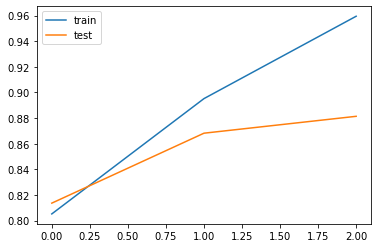

In [185]:
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

model_500 = Sequential()
model_500.add(Dense(502, activation='relu', input_shape=(502,)))
model_500.add(Dropout(0.2))
model_500.add(Dense(128, activation='relu'))
model_500.add(Dropout(0.2))
model_500.add(Dense(64, activation='relu'))
model_500.add(Dropout(0.2))
model_500.add(Dense(1, activation='sigmoid'))
model_500.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_500.fit(train_df_500, y_train, validation_data=(dev_df_500, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_500.evaluate(train_df_500, y_train, verbose=0)
_, test_acc = model_500.evaluate(dev_df_500, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Train on 1555 samples, validate on 531 samples
Epoch 1/4000
1555/1555 [==============================] - 2s 1ms/step - loss: 0.3696 - accuracy: 0.8392 - val_loss: 0.3139 - val_accuracy: 0.8757
Epoch 2/4000
1555/1555 [==============================] - 1s 694us/step - loss: 0.1239 - accuracy: 0.9556 - val_loss: 0.2982 - val_accuracy: 0.9077
Epoch 3/4000
1555/1555 [==============================] - 1s 707us/step - loss: 0.0434 - accuracy: 0.9871 - val_loss: 0.4228 - val_accuracy: 0.9021
Epoch 00003: early stopping
Train: 0.999, Test: 0.902


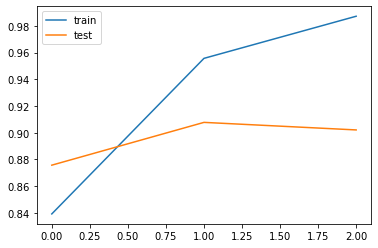

In [186]:
model_1000 = Sequential()
model_1000.add(Dense(1002, activation='relu', input_shape=(1002,)))
model_1000.add(Dropout(0.2))
model_1000.add(Dense(512, activation='relu'))
model_1000.add(Dropout(0.2))
model_1000.add(Dense(128, activation='relu'))
model_1000.add(Dropout(0.2))
model_1000.add(Dense(1, activation='sigmoid'))
model_1000.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_1000.fit(train_df_1000, y_train, validation_data=(dev_df_1000, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_1000.evaluate(train_df_1000, y_train, verbose=0)
_, test_acc = model_1000.evaluate(dev_df_1000, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [191]:
train_df_500

,sentiment,label,covid,coronavirus,people,new,virus,get,like,say,...,employee,continue,reality,lord,attack,law,x,order,post,id
0,0.586719,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.360938,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.566667,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.566667,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.700000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.520385,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1563,0.404365,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1564,0.505952,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1565,0.471154,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
def convert_to_binary(x):
    if x < 0.5:
        return 0
    else:
        return 1
    
predictions_500 = [convert_to_binary(y) for y in model_500.predict(test_df_500)]
predictions_1000 = [convert_to_binary(y) for y in model_1000.predict(test_df_1000)]

predictions_1000

ERROR! Session/line number was not unique in database. History logging moved to new session 212


[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [203]:
count = 0

for i in range(len(predictions_500)):
    if predictions_500[i] == predictions_1000[i]:
        count+=1
        
count/len(predictions_500)    

0.8994515539305301